In [7]:
import pandas as pd

file_path = "home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/csv/unmasked/merged_per_site/NEON_D12_YELL_DP1_L001-1_20230711_directional_reflectance__envi_merged.csv"

# Read only one row
preview = pd.read_csv(file_path, nrows=1)

print("COLUMN NAMES:")
print(preview.columns.tolist())

print("\nFIRST DATA ROW (as dict):")
print(preview.iloc[0].to_dict())


COLUMN NAMES:
['Pixel_Row', 'Pixel_Col', 'Easting', 'Northing', 'Reflectance_Resample_Landsat_5_TM_corrected_Band_1', 'Reflectance_Resample_Landsat_5_TM_corrected_Band_2', 'Reflectance_Resample_Landsat_5_TM_corrected_Band_3', 'Reflectance_Resample_Landsat_5_TM_corrected_Band_4', 'Reflectance_Resample_Landsat_5_TM_corrected_Band_5', 'Reflectance_Resample_Landsat_5_TM_corrected_Band_6', 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_1', 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_2', 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_3', 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_4', 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_5', 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_6', 'Reflectance_Resample_Landsat_8_OLI_corrected_Band_1', 'Reflectance_Resample_Landsat_8_OLI_corrected_Band_2', 'Reflectance_Resample_Landsat_8_OLI_corrected_Band_3', 'Reflectance_Resample_Landsat_8_OLI_corrected_Band_4', 'Reflectance_Resample_Landsat_8_OLI_co

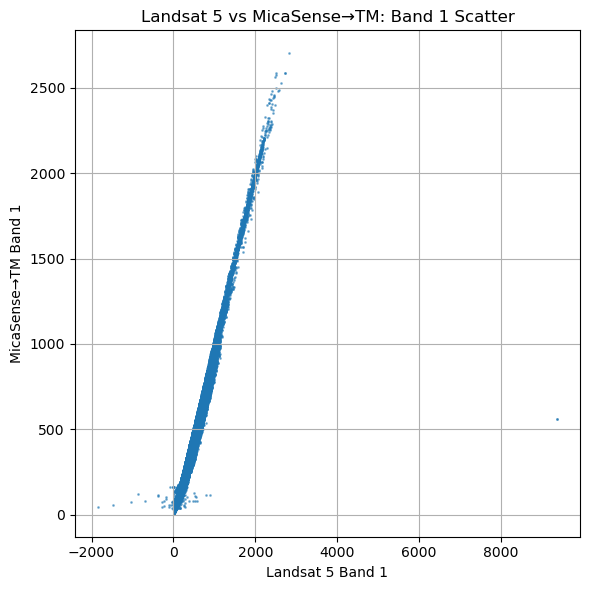

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Update this to the actual tempfile name
file_path = "/tmp/merged_site.csv"

cols = [
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_1",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_1"
]

# Load only the two columns (and a subset of rows)
df = pd.read_csv(file_path, usecols=cols, nrows=200_000)

plt.figure(figsize=(6,6))
plt.scatter(df[cols[0]], df[cols[1]], s=1, alpha=0.5)
plt.xlabel("Landsat 5 Band 1")
plt.ylabel("MicaSense→TM Band 1")
plt.title("Landsat 5 vs MicaSense→TM: Band 1 Scatter")
plt.grid(True)
plt.tight_layout()
plt.show()



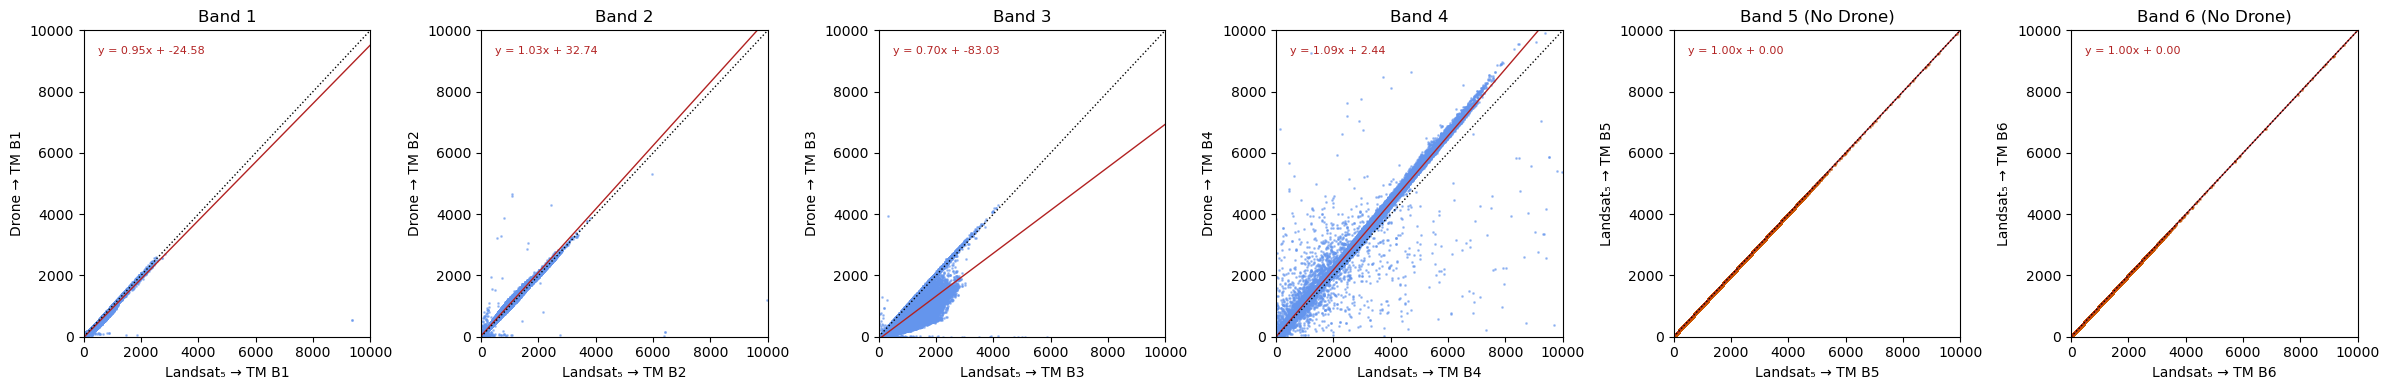

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# path to your CSV
file_path = "/tmp/merged_site.csv"

# define your two series of columns
landsat5_cols = [
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_1",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_2",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_3",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_4",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_5",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_6",
]
mica_tm_cols = [
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_1",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_2",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_3",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_4",
]

# read only the needed columns (and a subset of rows)
usecols = landsat5_cols + mica_tm_cols
df = pd.read_csv(file_path, usecols=usecols, nrows=200_000)

# ensure all values are positive & drop errors >10000
df[usecols] = df[usecols].abs()
df = df[(df[usecols] <= 10000).all(axis=1)]

# map band numbers to column names
ls_map = {int(re.search(r"Band_(\d+)", c).group(1)): c for c in landsat5_cols}
ms_map = {int(re.search(r"Band_(\d+)", c).group(1)): c for c in mica_tm_cols}

# determine which bands are common or unique
all_bands = sorted(ls_map.keys() | ms_map.keys())
common   = sorted(ls_map.keys() & ms_map.keys())
only_ls  = sorted(ls_map.keys() - ms_map.keys())
only_ms  = sorted(ms_map.keys() - ls_map.keys())

# create 1×N subplots
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_bands),
    figsize=(4 * len(all_bands), 4),
    squeeze=False
)
axes = axes[0]

for ax, b in zip(axes, all_bands):
    # select x and y per band
    if b in common:
        x = df[ls_map[b]]
        y = df[ms_map[b]]
        scatter_color = 'cornflowerblue'
        x_label = f"Landsat₅ → TM B{b}"
        y_label = f"Drone → TM B{b}"
        title = f"Band {b}"
    elif b in only_ls:
        x = df[ls_map[b]]; y = x
        scatter_color = '#CC5500'  # burnt orange
        x_label = y_label = f"Landsat₅ → TM B{b}"
        title = f"Band {b} (No Drone)"
    else:  # only_ms
        x = df[ms_map[b]]; y = x
        scatter_color = '#CC5500'  # burnt orange
        x_label = y_label = f"Drone → TM B{b}"
        title = f"Band {b} (No Landsat)"

    # scatter points
    ax.scatter(x, y, s=1, alpha=0.5, c=scatter_color)
    ax.set_title(title)

    # regression line in firebrick
    m, c = np.polyfit(x, y, 1)
    line_x = np.array([0, 10000])
    ax.plot(line_x, m * line_x + c, color='firebrick', linewidth=1)

    # 1:1 reference dotted line in black
    ax.plot(line_x, line_x, linestyle=':', linewidth=1, color='black')

    # annotate regression equation in matching firebrick
    eq_text = f"y = {m:.2f}x + {c:.2f}"
    ax.text(
        0.05 * 10000,
        0.95 * 10000,
        eq_text,
        ha='left', va='top',
        fontsize=8,
        color='firebrick'
    )

    # labels and fixed axes
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(0, 10000)
    ax.set_ylim(0, 10000)

    # remove grid
    ax.grid(False)

plt.tight_layout()
plt.show()


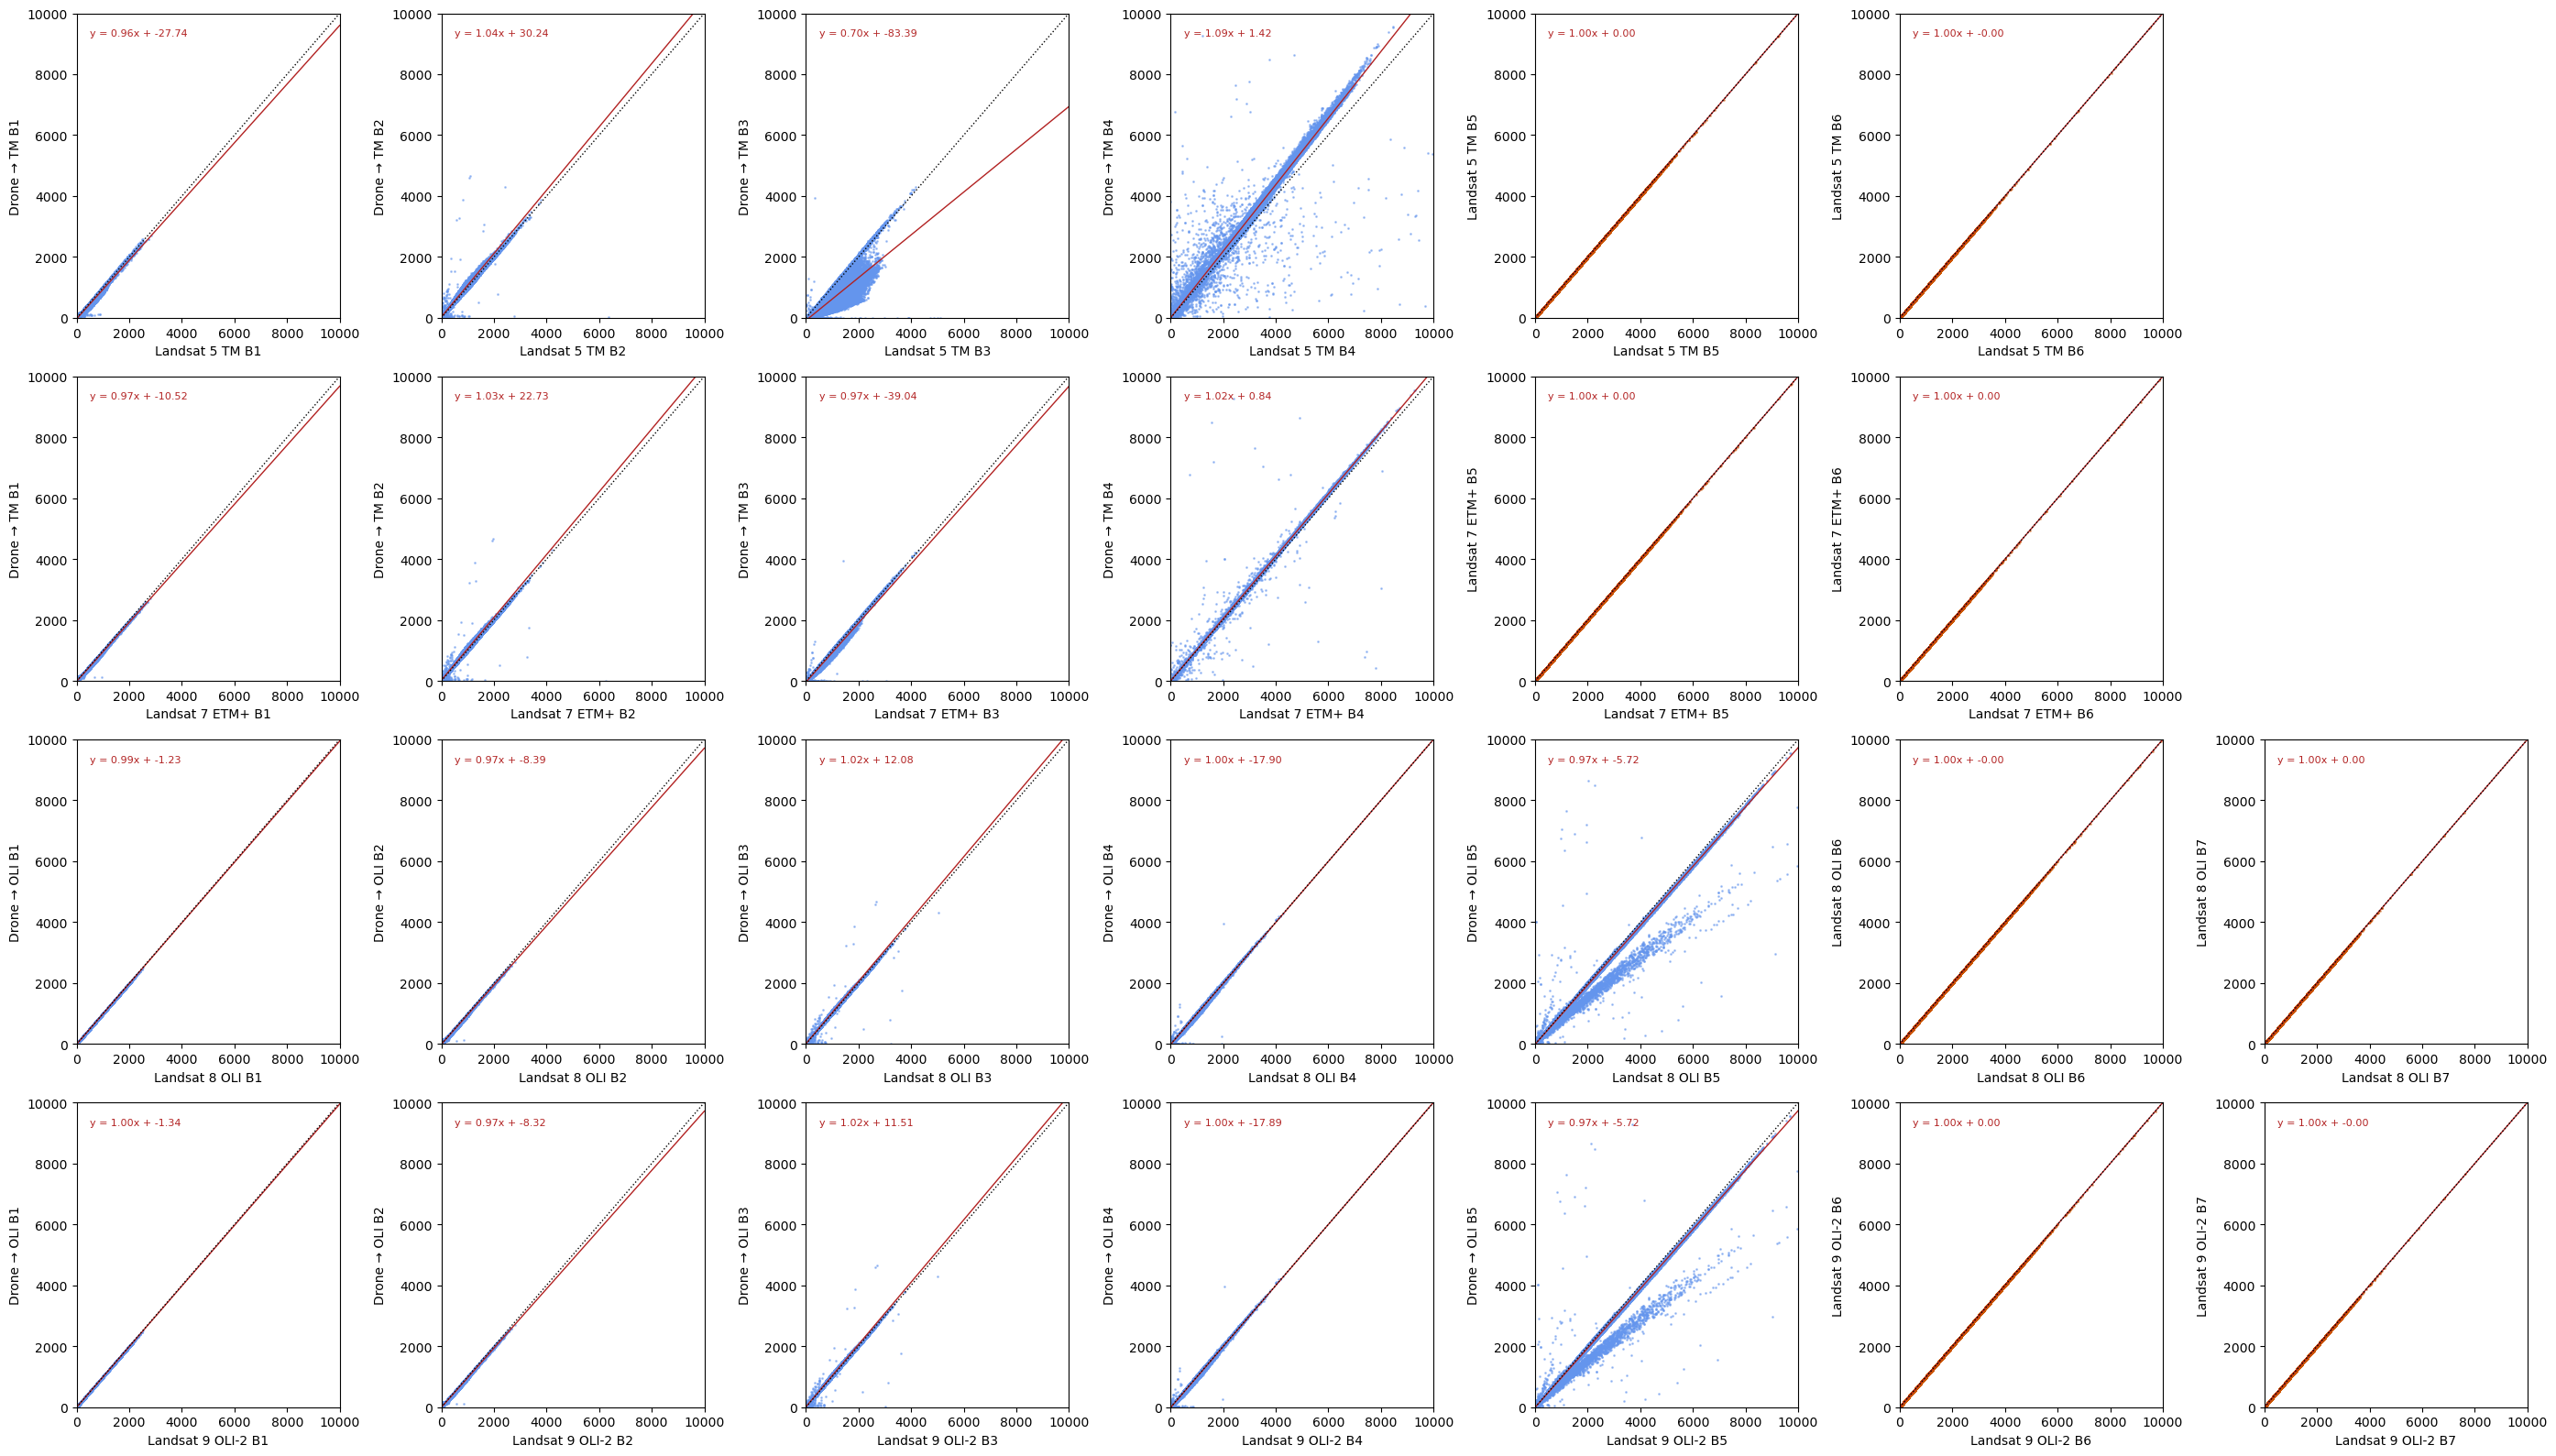

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# path to your CSV
file_path = "/tmp/merged_site.csv"

# define sensor‐specific prefixes and band lists
sensors = [
    {
        'name': 'Landsat 5 TM',
        'ls_prefix': 'Reflectance_Resample_Landsat_5_TM_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_',
        'ls_bands': list(range(1, 7)),
        'ms_bands': list(range(1, 5)),
    },
    {
        'name': 'Landsat 7 ETM+',
        'ls_prefix': 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_',
        'ls_bands': list(range(1, 7)),
        'ms_bands': list(range(1, 5)),
    },
    {
        'name': 'Landsat 8 OLI',
        'ls_prefix': 'Reflectance_Resample_Landsat_8_OLI_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_',
        'ls_bands': list(range(1, 8)),
        'ms_bands': list(range(1, 6)),
    },
    {
        'name': 'Landsat 9 OLI-2',
        'ls_prefix': 'Reflectance_Resample_Landsat_9_OLI-2_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_',
        'ls_bands': list(range(1, 8)),
        'ms_bands': list(range(1, 6)),
    },
]

# assemble all needed columns (raw, then dedupe to avoid duplicates)
raw_usecols = []
for s in sensors:
    raw_usecols += [f"{s['ls_prefix']}{b}" for b in s['ls_bands']]
    raw_usecols += [f"{s['ms_prefix']}{b}" for b in s['ms_bands']]
usecols = list(dict.fromkeys(raw_usecols))  # remove duplicates, keep order

# read & filter
df = pd.read_csv(file_path, usecols=usecols, nrows=200_000)
df[usecols] = df[usecols].abs()
df = df[(df[usecols] <= 10000).all(axis=1)]

# prepare subplot grid
n_rows = len(sensors)
n_cols = max(max(len(s['ls_bands']), len(s['ms_bands'])) for s in sensors)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

for i, s in enumerate(sensors):
    all_bands = sorted(set(s['ls_bands']) | set(s['ms_bands']))
    for j, b in enumerate(all_bands):
        ax = axes[i][j]

        # select x & y (None if missing)
        x = df.get(f"{s['ls_prefix']}{b}")
        y = df.get(f"{s['ms_prefix']}{b}")

        if x is not None and y is not None:
            scatter_color = 'cornflowerblue'
        else:
            # use whichever exists, plot x vs x
            x = x if x is not None else y
            y = x
            scatter_color = '#CC5500'

        ax.scatter(x, y, s=1, alpha=0.5, c=scatter_color)

        # regression line (firebrick)
        m, c0 = np.polyfit(x, y, 1)
        line_x = np.array([0, 10000])
        ax.plot(line_x, m*line_x + c0, color='firebrick', linewidth=1)

        # 1:1 reference line (dotted black)
        ax.plot(line_x, line_x, linestyle=':', linewidth=1, color='black')

        # equation annotation (firebrick)
        ax.text(0.05*10000, 0.95*10000,
                f"y = {m:.2f}x + {c0:.2f}",
                ha='left', va='top', fontsize=8, color='firebrick')

        # labels & fixed axes
        ax.set_xlabel(f"{s['name']} B{b}")
        if b in s['ms_bands']:
            suffix = 'TM' if 'TM' in s['name'] else 'OLI'
            ax.set_ylabel(f"Drone → {suffix} B{b}")
        else:
            ax.set_ylabel(f"{s['name']} B{b}")

        ax.set_xlim(0, 10000)
        ax.set_ylim(0, 10000)
        ax.grid(False)

    # hide unused subplots
    for j in range(len(all_bands), n_cols):
        axes[i][j].axis('off')

plt.tight_layout()
plt.show()


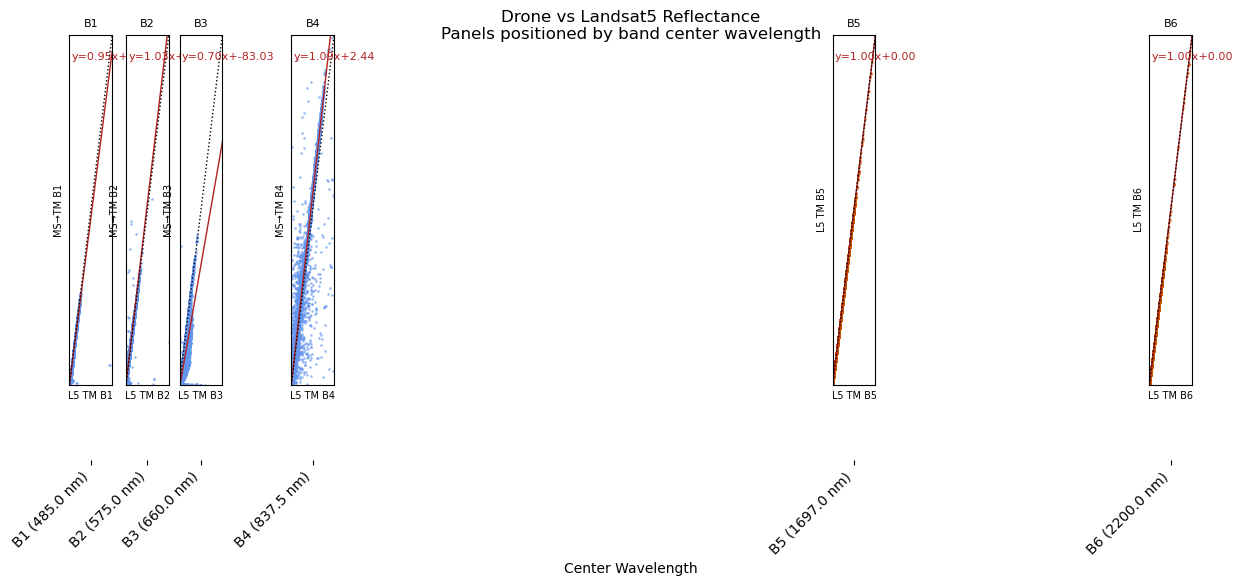

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# path to your CSV
file_path = "/tmp/merged_site.csv"  # ← update to your actual path

# prototype Landsat5 vs MicaSense→TM columns
landsat5_cols = [
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_1",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_2",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_3",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_4",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_5",
    "Reflectance_Resample_Landsat_5_TM_corrected_Band_6",
]
mica_tm_cols = [
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_1",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_2",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_3",
    "Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_4",
]

# load & filter
usecols = landsat5_cols + mica_tm_cols
df = pd.read_csv(file_path, usecols=usecols, nrows=200_000)
df[usecols] = df[usecols].abs()
df = df[(df[usecols] <= 10000).all(axis=1)]

# map band number → column
ls_map = {int(re.search(r"Band_(\d+)", c).group(1)): c for c in landsat5_cols}
ms_map = {int(re.search(r"Band_(\d+)", c).group(1)): c for c in mica_tm_cols}
all_bands = sorted(ls_map.keys() | ms_map.keys())

# hard‐code Landsat5 band center wavelengths (nm)
band_wl = {1: 485, 2: 575, 3: 660, 4: 837.5, 5: 1697, 6: 2200}
wl_min, wl_max = min(band_wl.values()), max(band_wl.values())

# figure
fig = plt.figure(figsize=(12, 5))
margin = 0.05

# map wavelength → normalized figure x‐coord
def map_wl(wl):
    return margin + (wl - wl_min) / (wl_max - wl_min) * (1 - 2*margin)

# compute positions and dynamic panel width
positions = np.array([map_wl(band_wl[b]) for b in all_bands])
min_dx = np.min(np.diff(np.sort(positions)))
panel_w = min_dx * 0.8  # 80% of smallest gap
panel_h = 0.7
y0 = 0.2

# bottom axis showing band centers with their real wavelengths
ax0 = fig.add_axes([margin, 0.05, 1 - 2*margin, 0.1])
ax0.set_xlim(wl_min, wl_max)
ticks = [band_wl[b] for b in all_bands]
labels = [f"B{b} ({band_wl[b]:.1f} nm)" for b in all_bands]
ax0.set_xticks(ticks)
ax0.set_xticklabels(labels, rotation=45, ha='right')
ax0.set_yticks([])
for sp in ax0.spines.values():
    sp.set_visible(False)
ax0.set_xlabel("Center Wavelength")

# draw mini‐plots
for idx, b in enumerate(all_bands):
    x0 = positions[idx] - panel_w/2
    ax = fig.add_axes([x0, y0, panel_w, panel_h])
    
    # select data
    if b in ls_map and b in ms_map:
        x = df[ls_map[b]]; y = df[ms_map[b]]
        color = 'cornflowerblue'
        xlabel = f"L5 TM B{b}"
        ylabel = f"MS→TM B{b}"
    elif b in ls_map:
        x = df[ls_map[b]]; y = x
        color = '#CC5500'
        xlabel = ylabel = f"L5 TM B{b}"
    else:
        x = df[ms_map[b]]; y = x
        color = '#CC5500'
        xlabel = ylabel = f"MS→TM B{b}"

    # scatter + regression + 1:1
    ax.scatter(x, y, s=1, alpha=0.5, c=color)
    m, c0 = np.polyfit(x, y, 1)
    xx = np.array([0, 10000])
    ax.plot(xx, m*xx + c0, color='firebrick', linewidth=1)
    ax.plot(xx, xx, linestyle=':', linewidth=1, color='black')
    ax.text(0.05*10000, 0.95*10000, f"y={m:.2f}x+{c0:.2f}",
            ha='left', va='top', fontsize=8, color='firebrick')

    # labels & clean up
    ax.set_title(f"B{b}", fontsize=8)
    ax.set_xlabel(xlabel, fontsize=7)
    ax.set_ylabel(ylabel, fontsize=7)
    ax.set_xlim(0, 10000); ax.set_ylim(0, 10000)
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle("Drone vs Landsat5 Reflectance\nPanels positioned by band center wavelength", y=0.95)
plt.show()


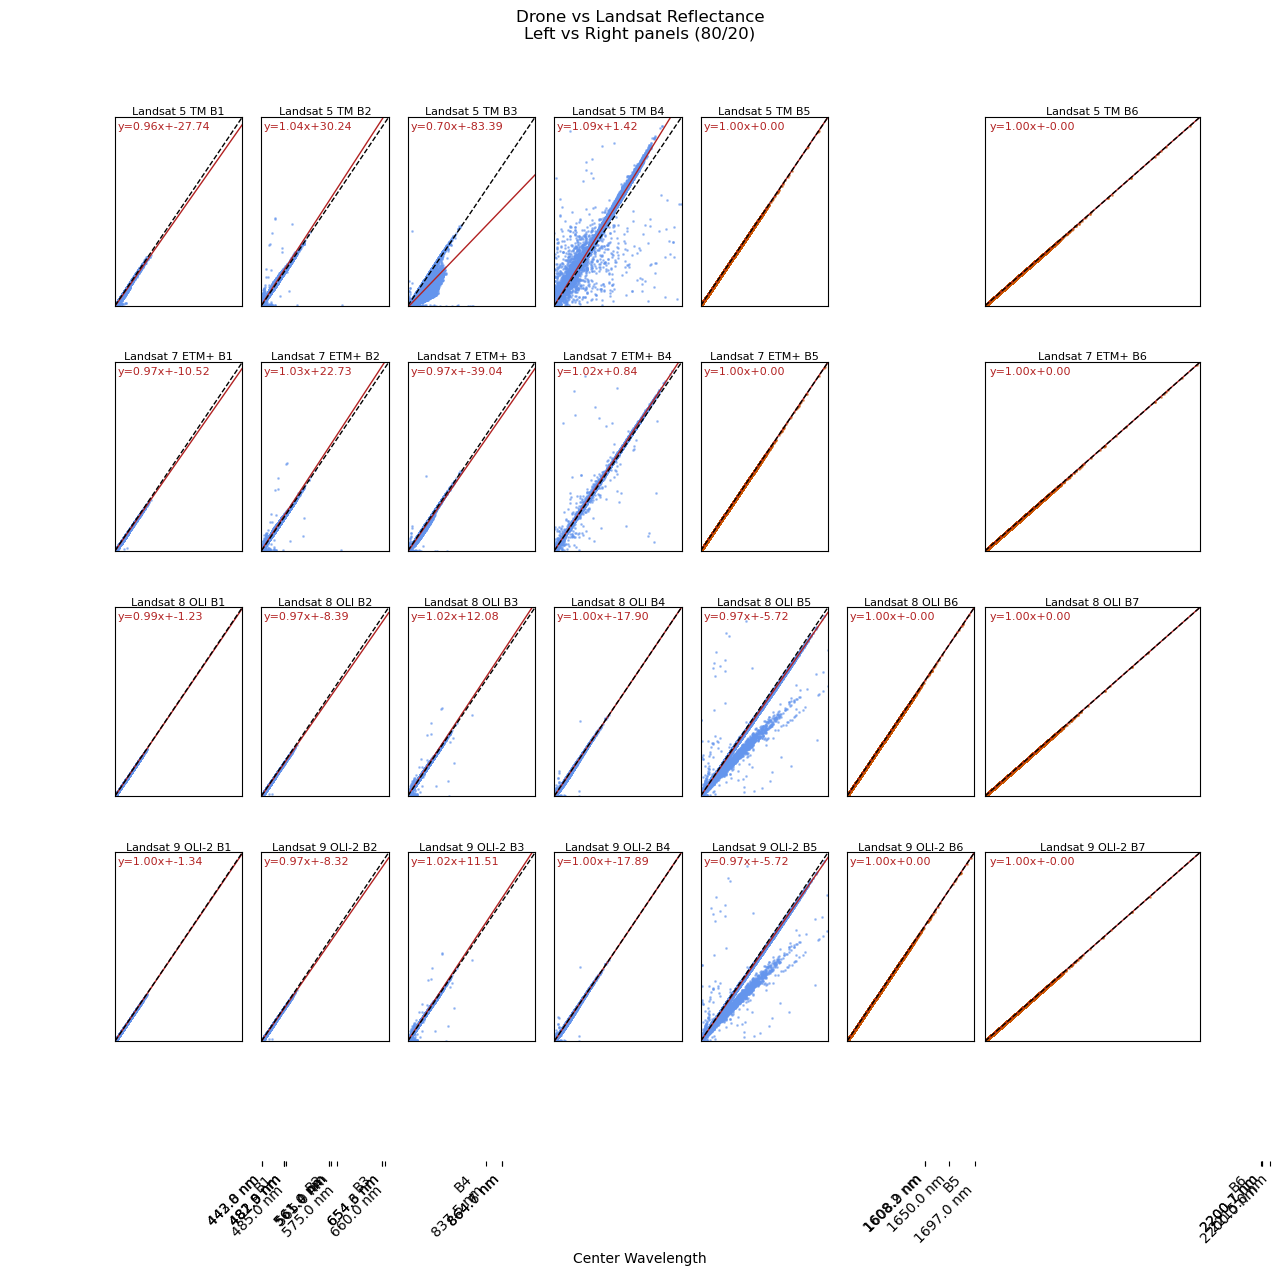

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- 1) Read & prepare data --------------------------------------------
file_path = "/tmp/merged_site.csv"  # ← your actual CSV
sensors = [
    {
        'name': 'Landsat 5 TM',
        'ls_cols': [f"Reflectance_Resample_Landsat_5_TM_corrected_Band_{b}"  for b in range(1,7)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_{b}" for b in range(1,5)],
        'wls':     [485, 575, 660, 837.5, 1697, 2200]
    },
    {
        'name': 'Landsat 7 ETM+',
        'ls_cols': [f"Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_{b}"  for b in range(1,7)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_{b}"  for b in range(1,5)],
        'wls':     [482.5, 565, 660, 837.5, 1650, 2215]
    },
    {
        'name': 'Landsat 8 OLI',
        'ls_cols': [f"Reflectance_Resample_Landsat_8_OLI_corrected_Band_{b}"  for b in range(1,8)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_{b}" for b in range(1,6)],
        'wls':     [443, 482, 561.4, 654.6, 864.7, 1608.9, 2200.7]
    },
    {
        'name': 'Landsat 9 OLI-2',
        'ls_cols': [f"Reflectance_Resample_Landsat_9_OLI-2_corrected_Band_{b}"  for b in range(1,8)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_{b}" for b in range(1,6)],
        'wls':     [442.8, 481.9, 561, 654.3, 864.6, 1608.2, 2200.1]
    },
]

# flatten & load columns
all_cols = []
for s in sensors:
    all_cols += s['ls_cols'] + s['ms_cols']
all_cols = list(dict.fromkeys(all_cols))

df = pd.read_csv(file_path, usecols=all_cols, nrows=200_000)
df[all_cols] = df[all_cols].abs()
df = df[(df[all_cols] <= 10000).all(axis=1)]

# --- 2) Parameters & indexing ------------------------------------------
break_pt    = sensors[0]['wls'][4]                 # 1697 nm
max_left    = max(sum(np.array(s['wls'])<= break_pt) for s in sensors)
n_rows      = len(sensors)

# --- 3) Set up figure & outer GridSpec -------------------------------
fig = plt.figure(figsize=(14, 12))
outer = GridSpec(1, 2, width_ratios=[4, 1], wspace=0.02)

# left sub-grid: all bands ≤ break_pt
left_gs  = outer[0].subgridspec(n_rows, max_left, hspace=0.3, wspace=0.15)
# right sub-grid: all bands > break_pt
right_gs = outer[1].subgridspec(n_rows, 1,      hspace=0.3)

# --- 4) Plot left panels -----------------------------------------------
for i, s in enumerate(sensors):
    ls_map = dict(zip(s['wls'], s['ls_cols']))
    ms_map = dict(zip(s['wls'][:len(s['ms_cols'])], s['ms_cols']))
    left_wls = [wl for wl in s['wls'] if wl <= break_pt]
    
    for j, wl in enumerate(left_wls):
        ax = fig.add_subplot(left_gs[i, j])
        x  = df[ls_map[wl]]
        if wl in ms_map:
            y, color = df[ms_map[wl]], 'cornflowerblue'
        else:
            y, color = x, '#CC5500'
        
        ax.scatter(x, y, s=1, alpha=0.5, c=color)
        m, b = np.polyfit(x, y, 1)
        xx = np.array([0, 10000])
        ax.plot(xx, m*xx+b, color='firebrick', lw=1)
        ax.plot(xx, xx, '--', color='black', lw=1)
        ax.text(0.02, 0.98, f"y={m:.2f}x+{b:.2f}",
                transform=ax.transAxes, ha='left', va='top',
                fontsize=8, color='firebrick')
        
        ax.set_title(f"{s['name']} B{int(s['wls'].index(wl)+1)}", fontsize=8, pad=2)
        ax.set_xlim(0,10000); ax.set_ylim(0,10000)
        ax.set_xticks([]); ax.set_yticks([])

    # hide any unused slots
    for j in range(len(left_wls), max_left):
        ax = fig.add_subplot(left_gs[i, j])
        ax.axis('off')


# --- 5) Plot right panels ----------------------------------------------
for i, s in enumerate(sensors):
    # rebuild mappings here!
    ls_map = dict(zip(s['wls'], s['ls_cols']))
    ms_map = dict(zip(s['wls'][:len(s['ms_cols'])], s['ms_cols']))
    
    right_wls = [wl for wl in s['wls'] if wl > break_pt]
    wl = right_wls[0] if right_wls else None
    
    ax = fig.add_subplot(right_gs[i, 0])
    if wl is not None:
        x = df[ls_map[wl]]
        if wl in ms_map:
            y, color = df[ms_map[wl]], 'cornflowerblue'
        else:
            y, color = x, '#CC5500'
        
        ax.scatter(x, y, s=1, alpha=0.5, c=color)
        m, b = np.polyfit(x, y, 1)
        xx = np.array([0, 10000])
        ax.plot(xx, m*xx+b, color='firebrick', lw=1)
        ax.plot(xx, xx, '--', color='black', lw=1)
        ax.text(0.02, 0.98, f"y={m:.2f}x+{b:.2f}",
                transform=ax.transAxes, ha='left', va='top',
                fontsize=8, color='firebrick')
        ax.set_title(f"{s['name']} B{int(s['wls'].index(wl)+1)}", fontsize=8, pad=2)

    ax.set_xlim(0,10000); ax.set_ylim(0,10000)
    ax.set_xticks([]); ax.set_yticks([])


# --- 6) Bottom wavelength axis -----------------------------------------
all_wls = sorted({wl for s in sensors for wl in s['wls']})
ax0 = fig.add_axes([0.05, 0.01, 0.9, 0.04])
ax0.set_xticks(all_wls)

labels = []
for wl in all_wls:
    if wl in sensors[0]['wls']:
        b = sensors[0]['wls'].index(wl)+1
        labels.append(f"B{b}\n{wl:.1f} nm")
    else:
        labels.append(f"{wl:.1f} nm")

ax0.set_xticklabels(labels, rotation=45, ha='right')
ax0.set_yticks([])
for spine in ax0.spines.values():
    spine.set_visible(False)
ax0.set_xlabel("Center Wavelength")

# --- 7) Finish up -------------------------------------------------------
plt.suptitle("Drone vs Landsat Reflectance\nLeft vs Right panels (80/20)", y=0.97)
plt.show()


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- 1) Load & clean the data ------------------------------------------
file_path = "/tmp/merged_site.csv"   # ← your actual CSV path
sensors = [
    {
        'name': 'Landsat 5 TM',
        'ls_cols': [f"Reflectance_Resample_Landsat_5_TM_corrected_Band_{b}" for b in range(1,7)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_{b}" for b in range(1,5)],
        'wls':     [485, 575, 660, 837.5, 1697, 2200]
    },
    {
        'name': 'Landsat 7 ETM+',
        'ls_cols': [f"Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_{b}" for b in range(1,7)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_{b}" for b in range(1,5)],
        'wls':     [482.5, 565, 660, 837.5, 1650, 2215]
    },
    {
        'name': 'Landsat 8 OLI',
        'ls_cols': [f"Reflectance_Resample_Landsat_8_OLI_corrected_Band_{b}" for b in range(1,8)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_{b}" for b in range(1,6)],
        'wls':     [443, 482, 561.4, 654.6, 864.7, 1608.9, 2200.7]
    },
    {
        'name': 'Landsat 9 OLI-2',
        'ls_cols': [f"Reflectance_Resample_Landsat_9_OLI-2_corrected_Band_{b}" for b in range(1,8)],
        'ms_cols': [f"Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_{b}" for b in range(1,6)],
        'wls':     [442.8, 481.9, 561, 654.3, 864.6, 1608.2, 2200.1]
    },
]

# Gather all needed columns and read in one pass
all_cols = []
for s in sensors:
    all_cols += s['ls_cols'] + s['ms_cols']
all_cols = list(dict.fromkeys(all_cols))

df = pd.read_csv(file_path, usecols=all_cols)
df = df.abs().clip(upper=10000)

# --- 2) Determine wavelength range & break point -----------------------
all_wls = np.hstack([s['wls'] for s in sensors])
wl_min, wl_max = all_wls.min(), all_wls.max()
# Break at Landsat 5 TM band 5 (1697 nm)
break_pt = sensors[0]['wls'][4]

# --- 3) Set up broken‐axis coordinates ---------------------------------
left_margin, right_margin = 0.05, 0.05
left_frac   = 0.85                         # Left region = 85% of width
full_frac   = 1 - right_margin             # Rightmost plotting edge
break_frac  = left_frac                    # Where the break sits

def map_wl(wl):
    if wl <= break_pt:
        # map into [left_margin, break_frac]
        return left_margin + (wl - wl_min) / (break_pt - wl_min) * (break_frac - left_margin)
    else:
        # map into [break_frac, full_frac]
        return break_frac + (wl - break_pt) / (wl_max - break_pt) * (full_frac - break_frac)

# --- 4) Build the figure layout ----------------------------------------
fig = plt.figure(figsize=(14,12))
n_rows   = len(sensors)
bottom_h = 0.05
top_h    = 0.03
row_h    = (1 - bottom_h - top_h) / n_rows
pad_v    = row_h * 0.1
panel_w  = 0.04
panel_h  = row_h * 0.8

# 5) Draw left/right background rectangles
fig.add_artist(Rectangle(
    (left_margin, bottom_h),
    break_frac - left_margin,
    1 - bottom_h - top_h,
    transform=fig.transFigure,
    color='lightblue', alpha=0.2, zorder=0
))
fig.add_artist(Rectangle(
    (break_frac, bottom_h),
    full_frac - break_frac,
    1 - bottom_h - top_h,
    transform=fig.transFigure,
    color='lightgrey', alpha=0.2, zorder=0
))

# 6) Bottom broken axis for wavelength labels
ax0 = fig.add_axes([left_margin, 0.01, full_frac - left_margin, bottom_h - 0.01])
ticks  = np.sort(np.unique(all_wls))
labels = []
for wl in ticks:
    if wl in sensors[0]['wls']:
        b = sensors[0]['wls'].index(wl) + 1
        labels.append(f"B{b}\n{wl:.1f} nm")
    else:
        labels.append(f"{wl:.1f} nm")
ax0.set_xlim(wl_min, wl_max)
ax0.set_xticks(ticks)
ax0.set_xticklabels(labels, rotation=45, ha='right')
ax0.set_yticks([])
for sp in ax0.spines.values():
    sp.set_visible(False)
ax0.set_xlabel("Center Wavelength (broken)")

# 7) Plot each sensor’s panels
for i, s in enumerate(sensors):
    ls_map = dict(zip(s['wls'], s['ls_cols']))
    ms_map = dict(zip(s['wls'][:len(s['ms_cols'])], s['ms_cols']))
    y0     = bottom_h + (n_rows - i - 1) * row_h + pad_v
    for wl in s['wls']:
        x0 = map_wl(wl) - panel_w/2
        ax = fig.add_axes([x0, y0, panel_w, panel_h], facecolor='none')
        x = df[ls_map[wl]]
        if wl in ms_map:
            y, color = df[ms_map[wl]], 'cornflowerblue'
        else:
            y, color = x, '#CC5500'
        ax.scatter(x, y, s=1, alpha=0.5, c=color)
        m, b0 = np.polyfit(x, y, 1)
        xx = np.array([0,10000])
        ax.plot(xx, m*xx + b0, color='firebrick', linewidth=1)
        ax.plot(xx, xx, linestyle=':', color='black', linewidth=1)
        ax.text(0.02, 0.98, f"y={m:.2f}x+{b0:.2f}",
                transform=ax.transAxes, ha='left', va='top',
                fontsize=8, color='firebrick')
        ax.set_title(f"{s['name']} B{int(s['wls'].index(wl)+1)}", fontsize=8, pad=1)
        ax.set_xlim(0,10000); ax.set_ylim(0,10000)
        ax.set_xticks([]); ax.set_yticks([])

# 8) Finalize & save
plt.suptitle("Drone vs Landsat Reflectance\nBroken axis (left 85% / right 10%)", y=0.98)
plt.savefig("broken_axis_reflectance.png", dpi=300, bbox_inches="tight")
plt.close(fig)


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# path to your CSV
file_path = "/tmp/merged_site.csv"

# define sensors
sensors = [
    {
        'name': 'Landsat 5 TM',
        'ls_prefix': 'Reflectance_Resample_Landsat_5_TM_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_',
        'ls_bands': list(range(1, 7)),
        'ms_bands': list(range(1, 5)),
    },
    {
        'name': 'Landsat 7 ETM+',
        'ls_prefix': 'Reflectance_Resample_Landsat_7_ETMplus_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_TM_corrected_Band_',
        'ls_bands': list(range(1, 7)),
        'ms_bands': list(range(1, 5)),
    },
    {
        'name': 'Landsat 8 OLI',
        'ls_prefix': 'Reflectance_Resample_Landsat_8_OLI_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_',
        'ls_bands': list(range(1, 8)),
        'ms_bands': list(range(1, 6)),
    },
    {
        'name': 'Landsat 9 OLI-2',
        'ls_prefix': 'Reflectance_Resample_Landsat_9_OLI-2_corrected_Band_',
        'ms_prefix': 'Reflectance_Resample_MicaSense_to_match_OLI_corrected_Band_',
        'ls_bands': list(range(1, 8)),
        'ms_bands': list(range(1, 6)),
    },
]

# assemble columns
raw_usecols = []
for s in sensors:
    raw_usecols += [f"{s['ls_prefix']}{b}" for b in s['ls_bands']]
    raw_usecols += [f"{s['ms_prefix']}{b}" for b in s['ms_bands']]
usecols = list(dict.fromkeys(raw_usecols))

# read & filter
df = pd.read_csv(file_path, usecols=usecols, nrows=200_000)
df[usecols] = df[usecols].abs()
df = df[(df[usecols] <= 10000).all(axis=1)]

# prepare subplot grid
n_rows = len(sensors)
n_cols = max(max(len(s['ls_bands']), len(s['ms_bands'])) for s in sensors) + 1  # add one for shift
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

for i, s in enumerate(sensors):
    # shift top two rows to the right by 1
    offset = 1 if i < 2 else 0

    all_bands = sorted(set(s['ls_bands']) | set(s['ms_bands']))
    for j, b in enumerate(all_bands):
        ax = axes[i][j + offset]

        # select x & y
        x = df.get(f"{s['ls_prefix']}{b}")
        y = df.get(f"{s['ms_prefix']}{b}")
        if x is not None and y is not None:
            color = 'cornflowerblue'
        else:
            x = x if x is not None else y
            y = x
            color = '#CC5500'

        ax.scatter(x, y, s=1, alpha=0.5, c=color)

        # regression and 1:1
        m, c0 = np.polyfit(x, y, 1)
        line_x = np.array([0, 10000])
        ax.plot(line_x, m*line_x + c0, color='firebrick', linewidth=1)
        ax.plot(line_x, line_x, ':', color='black', linewidth=1)
        ax.text(0.05*10000, 0.95*10000,
                f"y = {m:.2f}x + {c0:.2f}",
                ha='left', va='top', fontsize=8, color='firebrick')

        # labels & axes
        ax.set_xlabel(f"{s['name']} B{b}")
        if b in s['ms_bands']:
            suffix = 'TM' if 'TM' in s['name'] else 'OLI'
            ax.set_ylabel(f"Drone → {suffix} B{b}")
        else:
            ax.set_ylabel(f"{s['name']} B{b}")
        ax.set_xlim(0, 10000)
        ax.set_ylim(0, 10000)
        ax.grid(False)

    # hide unused subplots (including the empty first column for top two rows)
    for j in range(n_cols):
        if j < offset or j - offset >= len(all_bands):
            axes[i][j].axis('off')

plt.tight_layout()

# save to PNG
plt.savefig("shifted_reflectance_plots.png", dpi=300, bbox_inches="tight")
plt.close(fig)
print("Saved figure to shifted_reflectance_plots.png")


Saved figure to shifted_reflectance_plots.png
